In [1]:
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2022-04-02 09:10:59.073447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-02 09:10:59.073563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
epochs = 50
number_of_examples = 16
batch_size = 32
latent_dim = 100
image_size = (32, 32) # h x w

image_seed = tf.random.normal([number_of_examples, latent_dim])
label_seed = tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])

number_of_classes = 10

2022-04-01 18:03:07.794048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 18:03:07.794097: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 18:03:07.794129: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-04-01 18:03:07.794541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = (x_train - 127.5) / 127.5 #Normalizing

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).batch(batch_size, drop_remainder=True)

2022-04-01 18:03:12.732409: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1228800000 exceeds 10% of free system memory.


In [35]:
def make_generator_model(latent_dim):
    noise = keras.layers.Input(shape=[latent_dim], name="noise")
    label = keras.layers.Input(shape=(1, ), name="label")
    
    label_embedding = keras.layers.Embedding(number_of_classes, latent_dim, name="embedding")(label)
    
    label_embedding = keras.layers.Flatten(name="flatten")(label_embedding)
    
    gen_input = keras.layers.Multiply(name="multiply")([noise, label_embedding])
    
    hidden = keras.layers.Reshape((1, 1, latent_dim), name="reshape")(gen_input)
    
    hidden = keras.layers.Conv2DTranspose(512, 4, 1, 'valid')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)
    
    hidden = keras.layers.Conv2DTranspose(256, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)
    
    hidden = keras.layers.Conv2DTranspose(128, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)
    
    hidden = keras.layers.Conv2DTranspose(3, 3, 2, 'same')(hidden)
    out = keras.layers.Activation("tanh")(hidden)

    return keras.Model(inputs=[noise, label], outputs=out)

In [36]:
generator = make_generator_model(latent_dim)

In [37]:
noise = keras.layers.Input(shape=[latent_dim])

hidden = keras.layers.Reshape((1, 1, latent_dim), name="reshape")(noise)
    
hidden = keras.layers.Conv2DTranspose(512, 4, 1, 'valid')(hidden)
hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2DTranspose(256, 3, 2, 'same')(hidden)
hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2DTranspose(128, 3, 2, 'same')(hidden)
hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2DTranspose(3, 3, 2, 'same')(hidden)
out = keras.layers.Activation("tanh")(hidden)

generator = keras.models.Model(noise, out, name="generator")

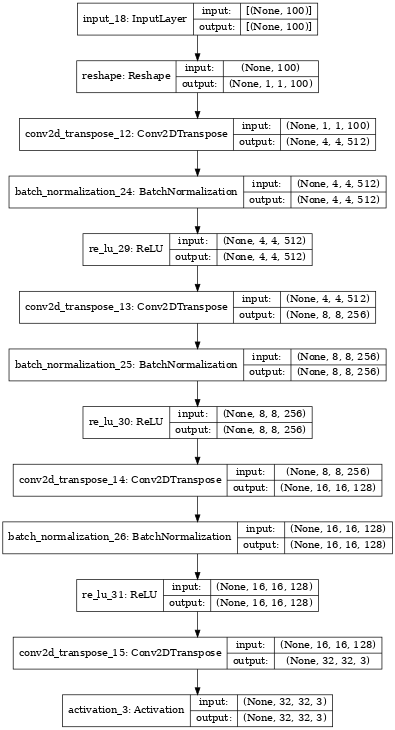

In [38]:
keras.utils.plot_model(generator, dpi=50, show_shapes=True)

In [40]:
noise = keras.layers.Input(shape=[latent_dim], name="noise")
label = keras.layers.Input(shape=(1, ), name="label")
label_embedding = keras.layers.Embedding(number_of_classes, latent_dim, name="embedding")(label)
label_embedding = keras.layers.Flatten(name="flatten")(label_embedding)    
gen_input = keras.layers.Multiply(name="multiply")([noise, label_embedding])

generator_model = generator(gen_input)

label_cond_generator = keras.models.Model([noise, label], generator_model)

In [41]:
label_cond_generator.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        label[0][0]                      
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
___________________________________________________________________________________________

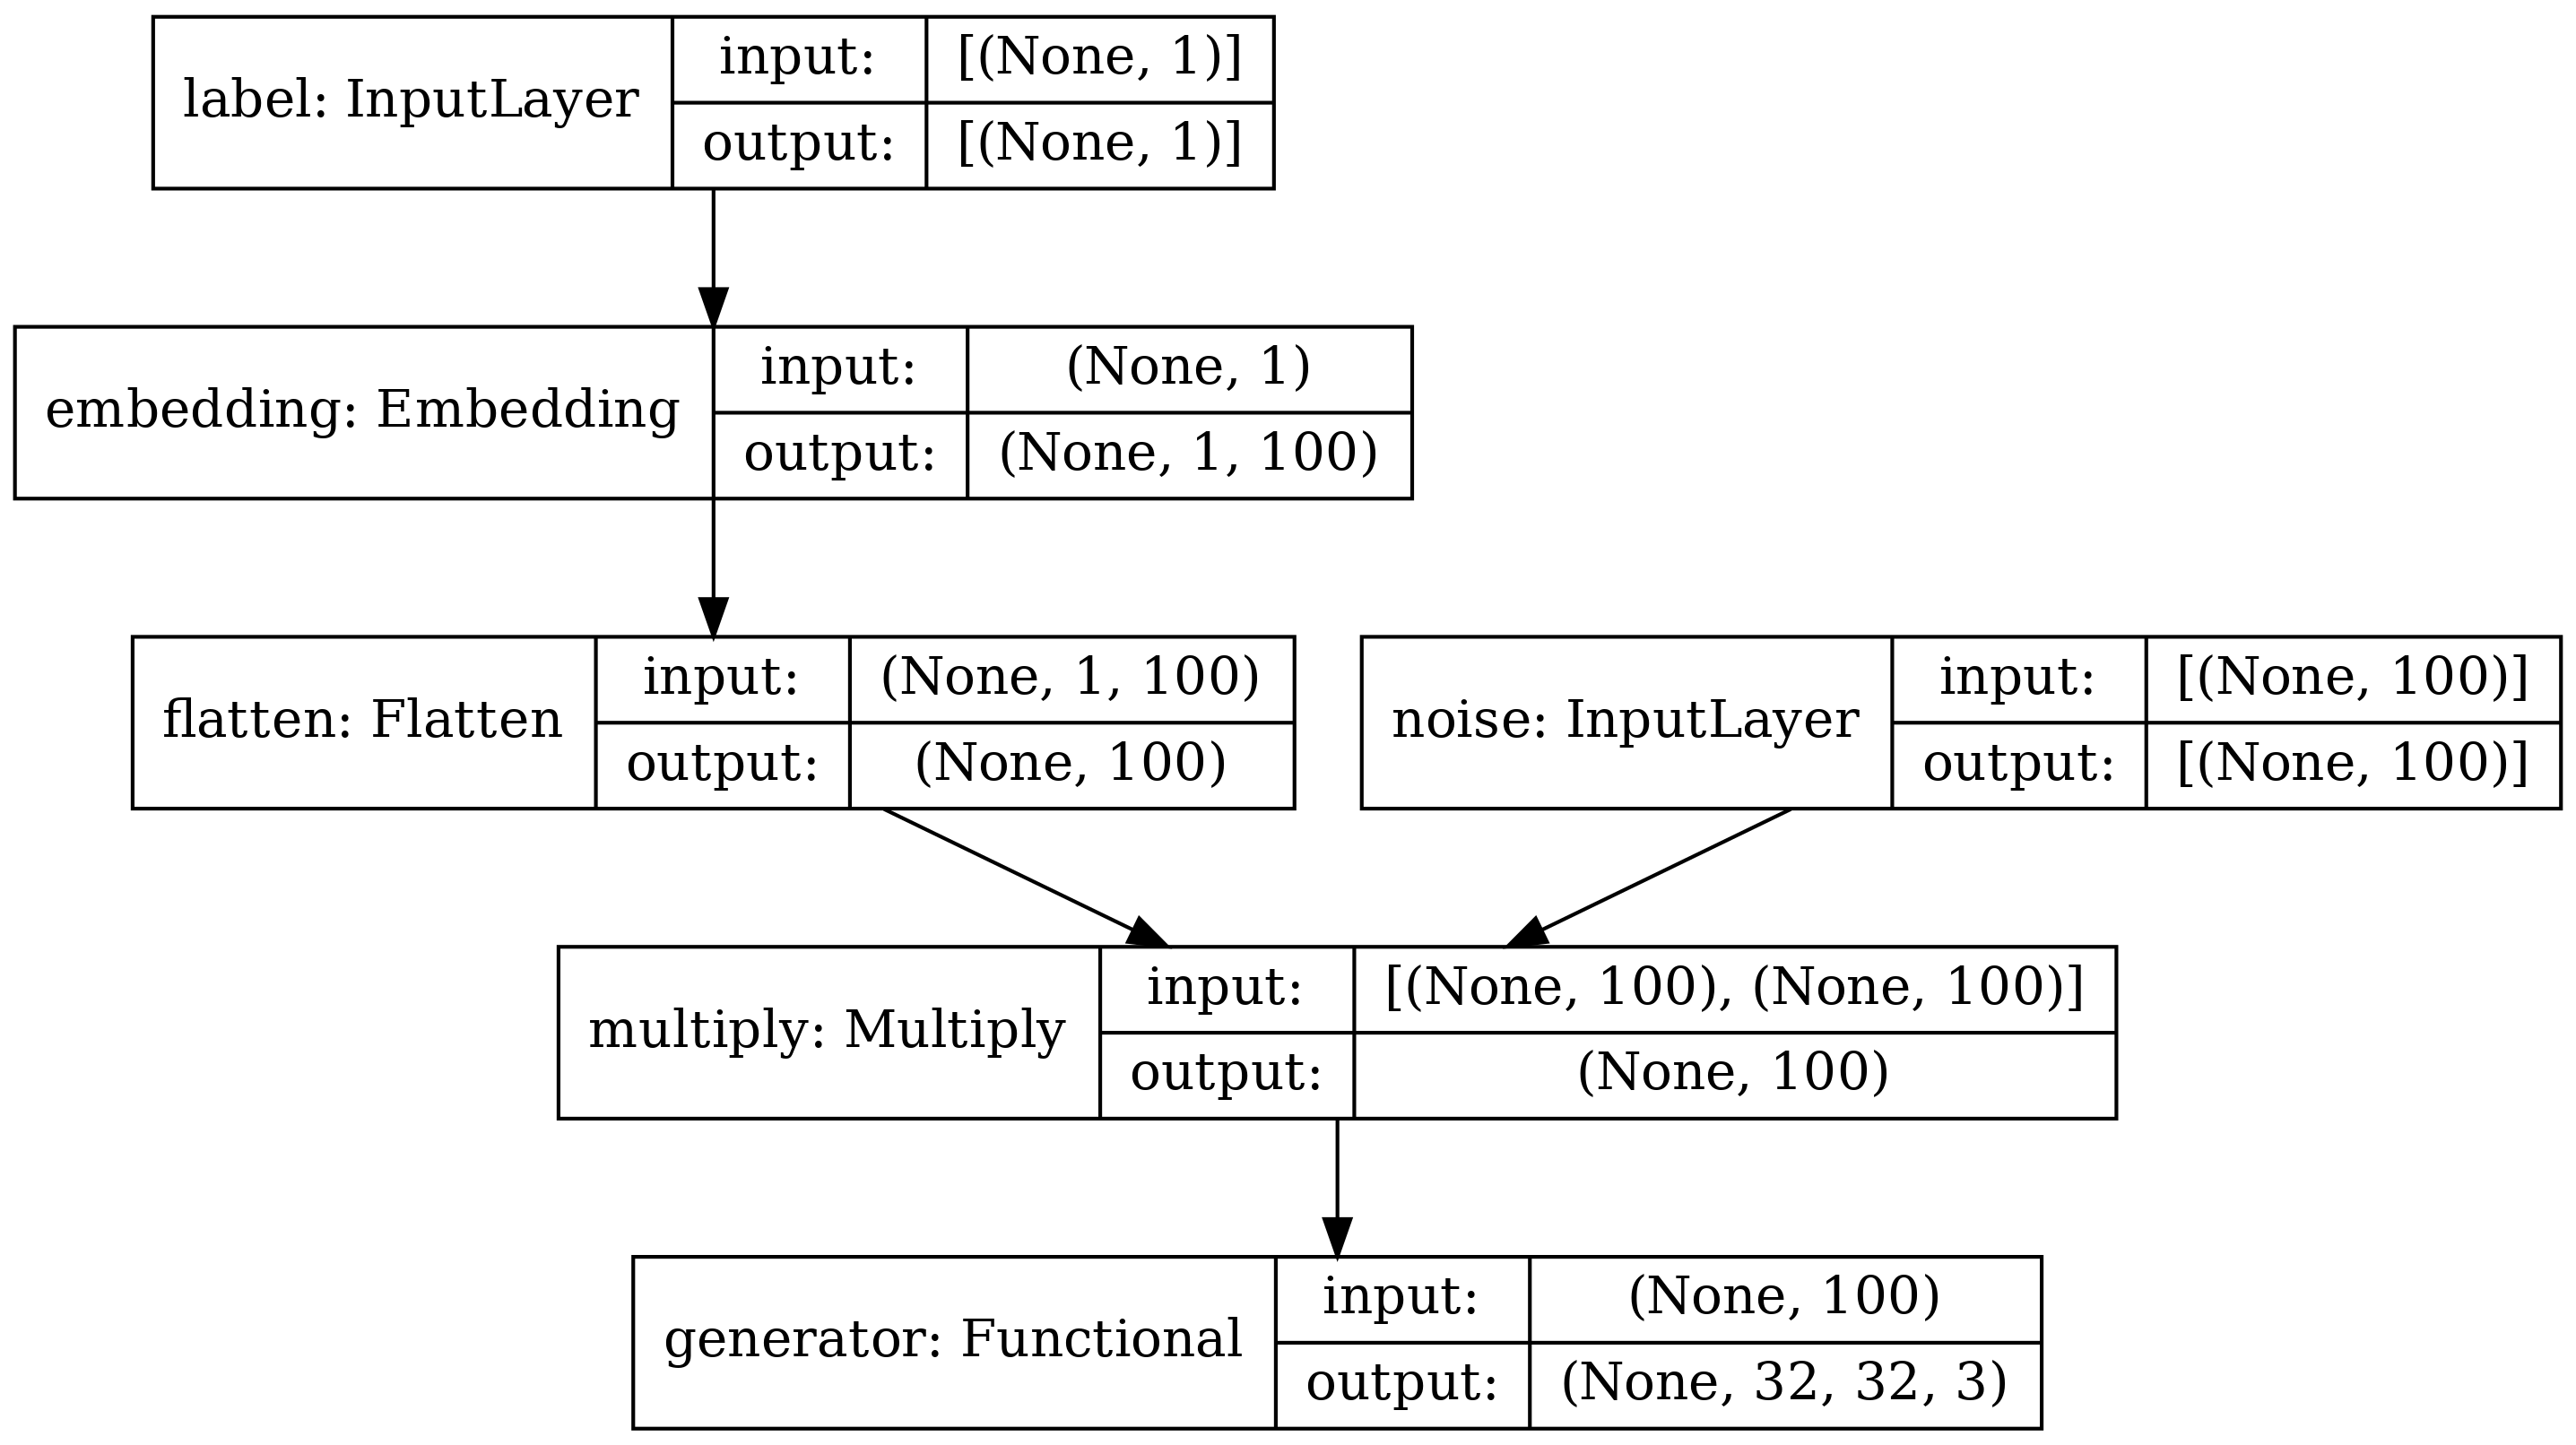

In [49]:
keras.utils.plot_model(label_cond_generator, dpi=300, show_shapes=True)

In [12]:
def make_discriminator_model():
    image = keras.layers.Input(shape=(32, 32, 3))
    
    label = keras.layers.Input(shape=(1, ))
    
    hidden = keras.layers.Conv2D(128, 3, 2, 'same')(image)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)
    
    hidden = keras.layers.Conv2D(256, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)
    
    hidden = keras.layers.Conv2D(512, 3, 2, 'same')(hidden)
    hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
    hidden = keras.layers.ReLU()(hidden)
    
    hidden = keras.layers.Conv2D(latent_dim, 4, 1, 'valid', name="convka")(hidden)
    hidden = keras.layers.ReLU()(hidden)
    features = keras.layers.Flatten()(hidden)
    
    label_embedding = keras.layers.Embedding(number_of_classes, latent_dim)(label)
    
    label_embedding = keras.layers.Flatten()(label_embedding)
    
    embedded_space = keras.layers.Multiply()([features, label_embedding]) 
    
    hidden = keras.layers.Dropout(0.3)(embedded_space)
    
    out = keras.layers.Dense(1, name="output")(hidden)
    
    return keras.Model(inputs=[image, label], outputs=out)

In [13]:
discriminator = make_discriminator_model()

In [14]:
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 128)  3584        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 16, 16, 128)  512         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu_6 (ReLU)                  (None, 16, 16, 128)  0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

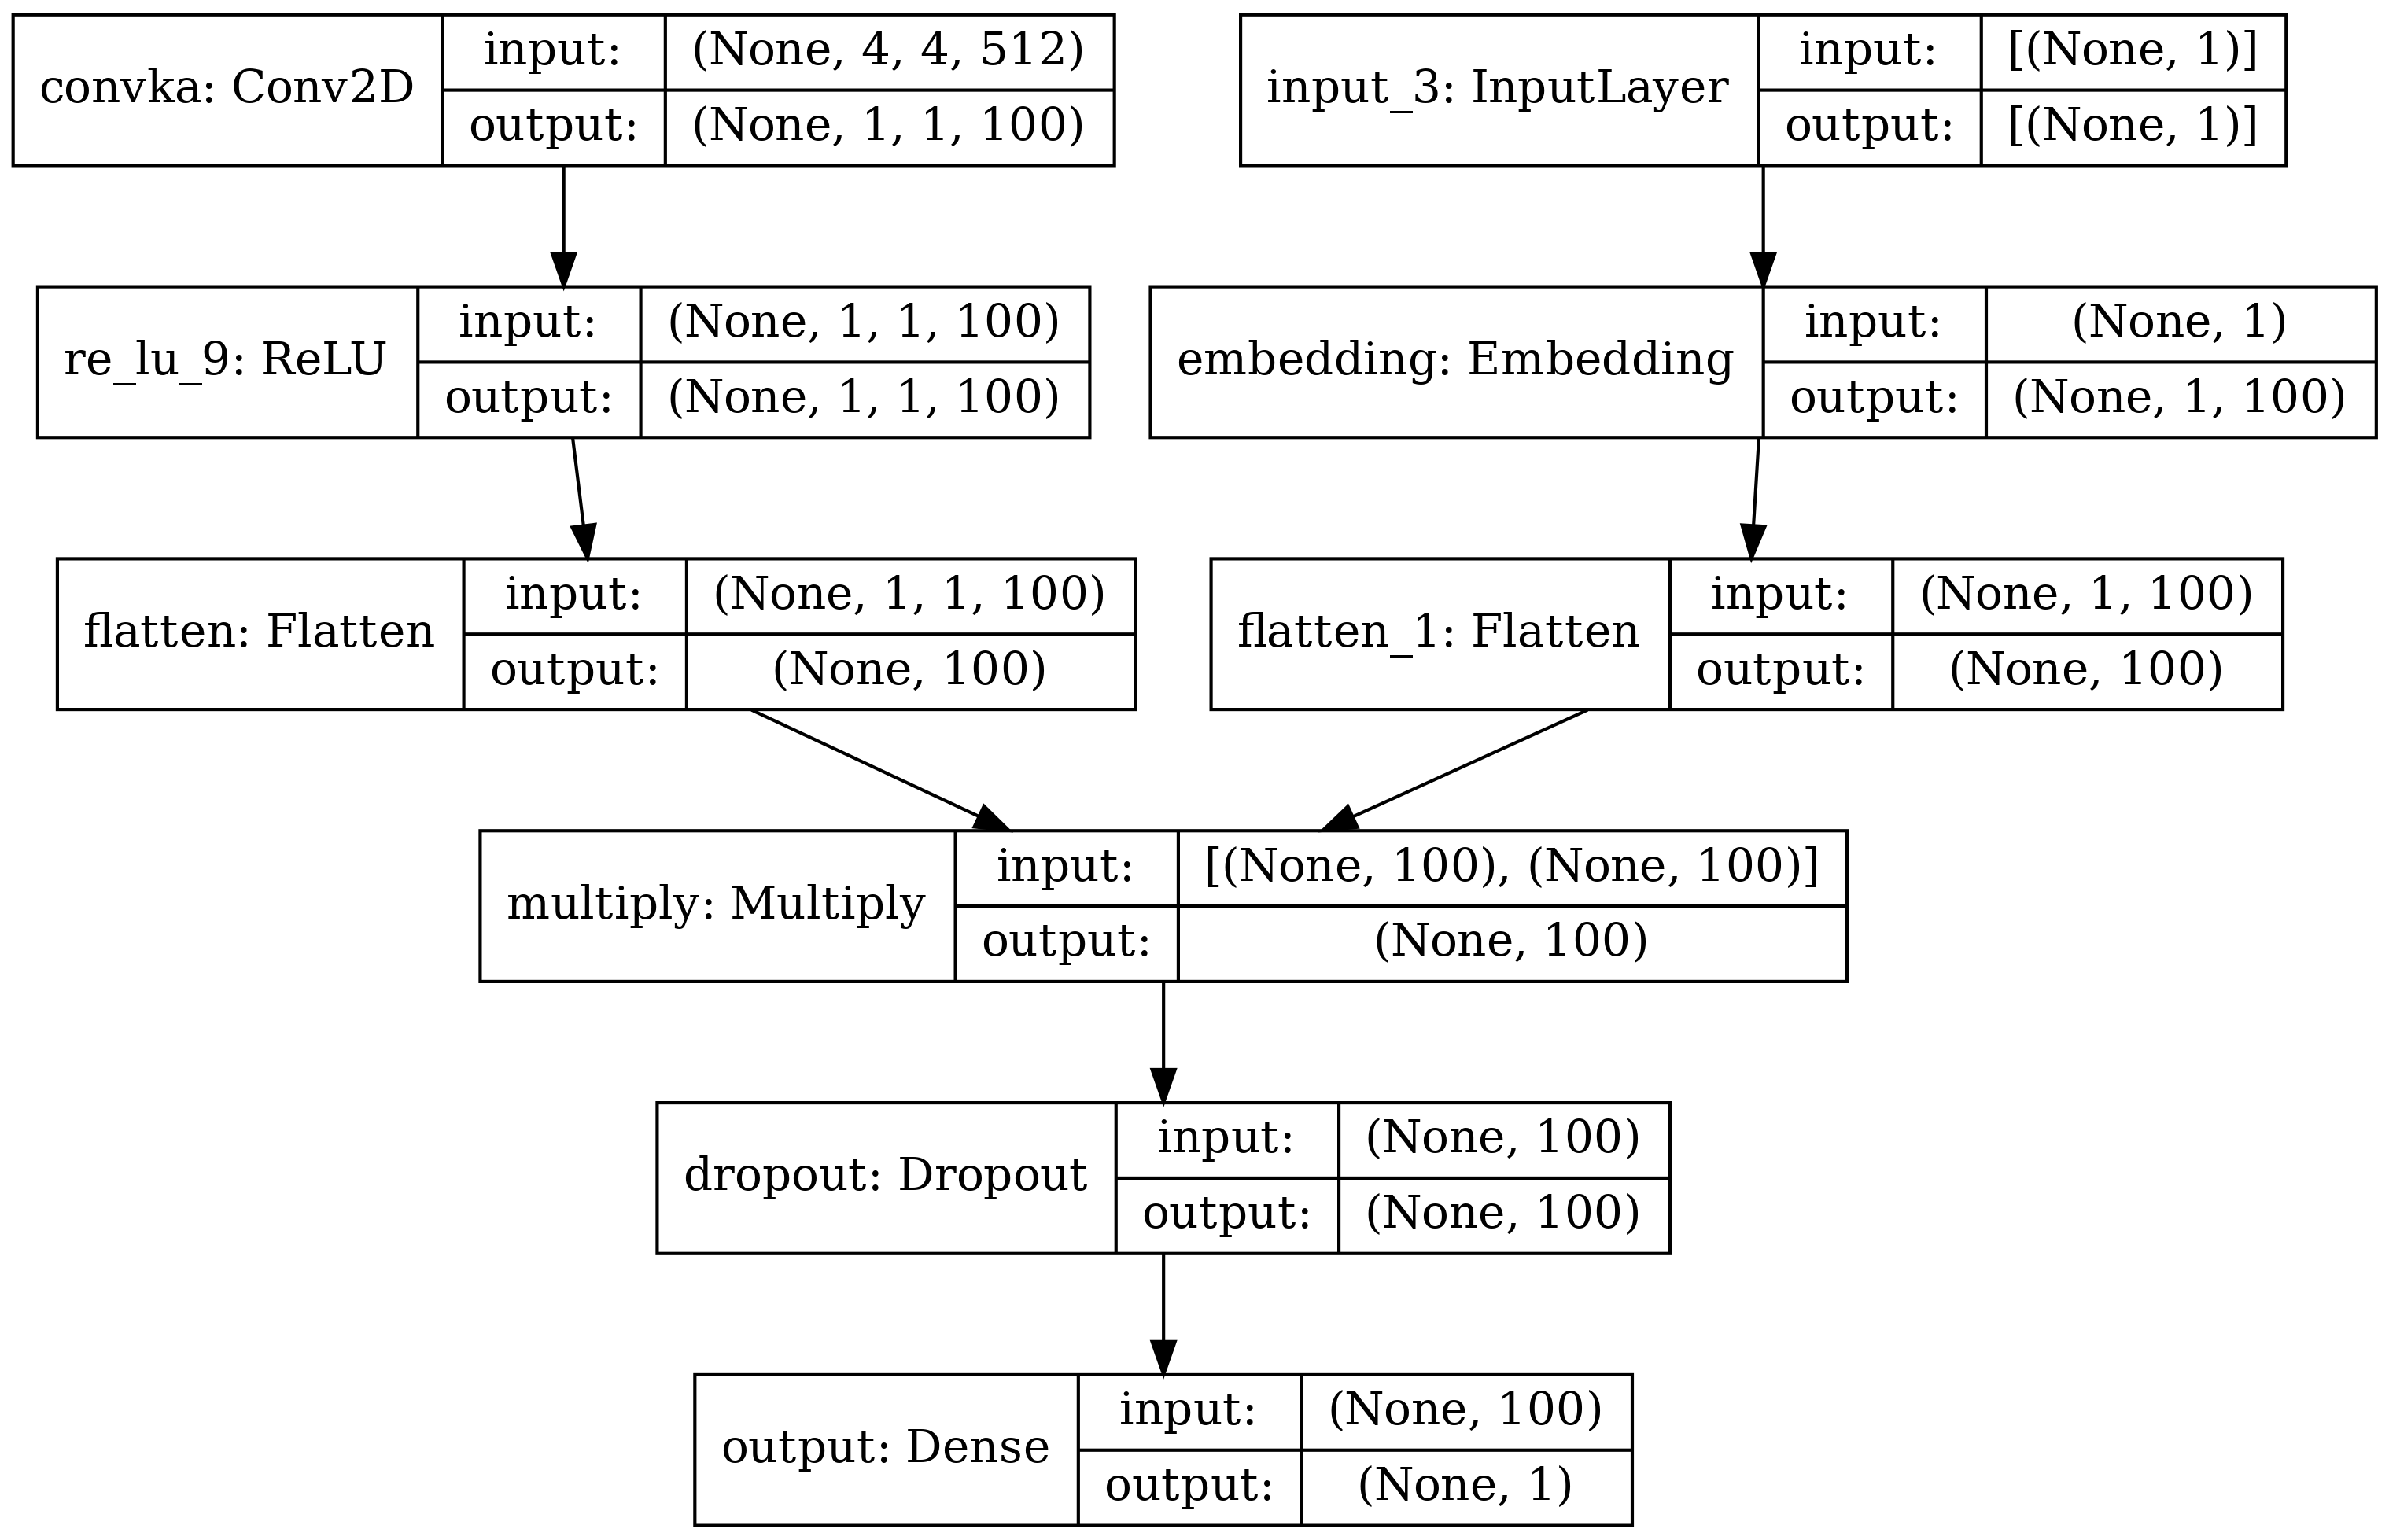

In [50]:
keras.utils.plot_model(discriminator, dpi=300, show_shapes=True, layer_range=["convka","output"])

In [29]:
image = keras.layers.Input(shape=(32, 32, 3))

hidden = keras.layers.Conv2D(128, 3, 2, 'same')(image)
hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2D(256, 3, 2, 'same')(hidden)
hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2D(512, 3, 2, 'same')(hidden)
hidden = keras.layers.BatchNormalization(momentum=0.9)(hidden)
hidden = keras.layers.ReLU()(hidden)
    
hidden = keras.layers.Conv2D(latent_dim, 4, 1, 'valid', name="convka")(hidden)
hidden = keras.layers.ReLU()(hidden)
features = keras.layers.Flatten()(hidden)

feature_extractor = keras.models.Model(image, features, name="featureExtractor")

In [30]:
feature_extractor.summary()

Model: "featureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu_23 (ReLU)              (None, 8, 8, 256)    

In [53]:
image = keras.layers.Input(shape=(32, 32, 3), name="image")

label = keras.layers.Input(shape=(1, ), name="label")

features = feature_extractor(image)

label_embedding = keras.layers.Embedding(number_of_classes, latent_dim, name="embedding")(label)
label_embedding = keras.layers.Flatten(name="flatten")(label_embedding)
embedded_space = keras.layers.Multiply(name="multiply")([features, label_embedding]) 

hidden = keras.layers.Dropout(0.3, name="dropout")(embedded_space)
out = keras.layers.Dense(1, name="output")(hidden)

label_discriminator = keras.models.Model([image, label], out)

In [56]:
asd = keras.utils.plot_model(label_discriminator, dpi=300, show_shapes=True)

In [63]:
print(asd)
import numpy as np



<IPython.core.display.Image object>


TypeError: Image data of dtype object cannot be converted to float

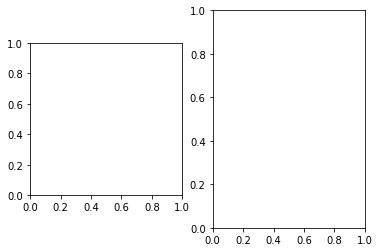

In [64]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.array(asd))

In [ ]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.constant(np.full(real_output.shape, 0.9)), real_output)
    fake_loss = cross_entropy(tf.constant(np.full(fake_output.shape, 0)), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(4e-4, beta_1=0.5)

In [ ]:
@tf.function
def train_step(images):
    train_images, train_labels = images
    
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator((noise, train_labels), training=True)

        real_output = discriminator((train_images, train_labels), training=True)
        fake_output = discriminator((generated_images, train_labels), training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator.trainable_variables
    )

    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator,
            generator.trainable_variables)
        )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator,
            discriminator.trainable_variables)
        )

    return (gen_loss, disc_loss)

In [ ]:
def plot_grid_of_images(images, epoch):
    plt.figure(figsize=(8, 8))

    for i in range(images.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow((images[i].numpy() * 127.5 + 127.5).astype("uint32"), interpolation="none")
        plt.axis('off')

    plt.show()

In [ ]:
def train(dataset, epochs):
    generator_losses = np.empty((0, 0), dtype=float)
    discriminator_losses = np.empty((0, 0), dtype=float)
    for epoch in range(epochs):
        start = time.time()
        
        batch_generator_losses = np.empty((0, 0), dtype=float)
        batch_discriminator_losses = np.empty((0, 0), dtype=float)
        for (batch, image_batch) in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            
            if batch % 500 == 0:
                average_batch_loss =\
                   gen_loss.numpy()/int(image_batch[0].shape[1])
                print(f"""Epoch {epoch+1}
                        Batch {batch} Loss {average_batch_loss:.4f}""")

            batch_generator_losses = np.append(batch_generator_losses, gen_loss)
            batch_discriminator_losses = np.append(batch_discriminator_losses, disc_loss)
        if generator_losses.shape == (0, 0):
            generator_losses = batch_generator_losses
            discriminator_losses = batch_discriminator_losses
        else:
            generator_losses = np.vstack(
                [generator_losses, batch_generator_losses]
            )
            discriminator_losses = np.vstack(
                [discriminator_losses, batch_discriminator_losses]
            )
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        example_images = generator((image_seed, label_seed), training=False)
        plot_grid_of_images(example_images, epoch)
    
    return (generator_losses, discriminator_losses)

In [ ]:
# Training the model
(generator_losses, discriminator_losses) = train(dataset, 20)

In [ ]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
noises = tf.random.normal([48, latent_dim])
for i in range(10):
    print(class_names[i])
    
    example_images = generator((noises, tf.constant(np.full(48, i))), training=False)
    plot_grid_of_images(example_images, 0)

In [ ]:
generator.save("generatorcifar10.h5")
discriminator.save("discriminatorcifar10.h5")